**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [67]:
import numpy as np
import pandas as pd

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [68]:
# input
DATASET_PATH = 'data/course_project_train.csv'

# test dataset
TEST_DATASET_PATH = 'data/course_project_test.csv'

# output
PREP_DATASET_PATH = 'data/course_project_data_prep.csv'

TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

In [69]:
df = pd.read_csv(DATASET_PATH)

In [70]:
df_train = df.copy()

In [71]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [72]:
len(df) - df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [73]:
def kde_plot(feature, sample_size=1000):
    feature_with_target_s = df_train[[feature, TARGET_NAME]].sample(sample_size)
    feature_s = feature_with_target_s[feature]
    feature_target_0 = feature_s[feature_with_target_s[TARGET_NAME] == 0]
    feature_target_1 = feature_s[feature_with_target_s[TARGET_NAME] == 1]

    plt.figure(figsize=(20, 10))

    sns.kdeplot(feature_target_0, shade=True, label='No default', color='g')
    sns.kdeplot(feature_target_1, shade=True, label='Default', color='r')

    plt.xlabel(feature)
    plt.title(f'{feature} grouped by target variable')
    plt.show() 
    
    print(mannwhitneyu(feature_target_0, feature_target_1))
    
    return feature_with_target_s, feature_s 

In [74]:
def distr_qq_plots(feature, feature_s):
    plt.figure(figsize=(20, 8))

    ax1 = plt.subplot(121)
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{feature} distribution')
    feature_s.hist()

    plt.subplot(122)
    probplot(feature_s, dist='norm', plot=plt)

    plt.show()

In [75]:
def research(feature):
    feature_with_target_s, feature_s = kde_plot(feature)
    
    distr_qq_plots(feature, feature_s)
    
    plt.figure(figsize=(8, 5))

    sns.pointplot(x=TARGET_NAME, y=feature, data=feature_with_target_s, capsize=.1)

    plt.title(f'Confidence intervals (95 %) for {feature}')
    plt.show()

In [76]:
list(df_train.columns)

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default']

In [77]:
feature = 'Years in current job'

In [78]:
df_train[feature]

0             NaN
1       10+ years
2         8 years
3         6 years
4         8 years
          ...    
7495     < 1 year
7496       1 year
7497      6 years
7498          NaN
7499      4 years
Name: Years in current job, Length: 7500, dtype: object

ValueError: could not convert string to float: '10+ years'

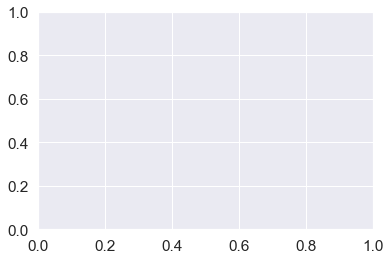

In [79]:
plt.scatter(df_train.index, df_train[feature])
plt.show

ValueError: could not convert string to float: '< 1 year'

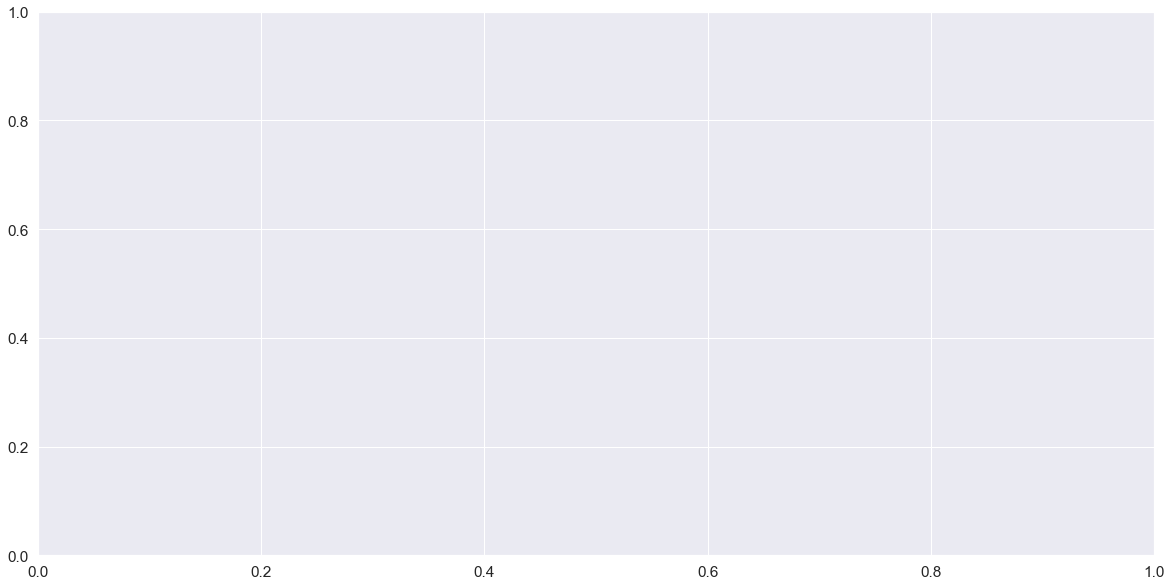

In [80]:
research(feature)